In [1]:
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt

from holotomocupy.holo import G
from holotomocupy.magnification import M
from holotomocupy.shift import S
from holotomocupy.utils import *

%matplotlib inline

np.random.seed(10)

astropy module not found
olefile module not found


# Init data sizes and parametes of the PXM of ID16A

In [2]:
n = 512  # object size in each dimension
pad = n//8

/tmp/ipykernel_950160/3603053017.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  return plt.cm.get_cmap(name, n)


7
parameters for recon:
size 1280
npos 49


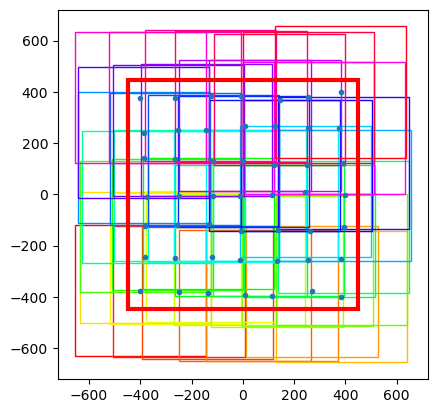

In [3]:
import matplotlib.patches as patches
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

fig, ax = plt.subplots()

step = n//4

npos = int(np.ceil((3*n/2+2*pad)/step))
print(npos)
cmap = get_cmap(npos**2)
shifts_code = np.zeros([1,npos**2,2],dtype='float32')
ipos = 0
for y in range(npos):
    for x in range(npos): 
        for k in range(1):       
            shifts_code[0,ipos,0] = int((y-npos/2+0.5)*step+(np.random.random(1)[0]-0.5)*n//16)
            shifts_code[0,ipos,1] = int((x-npos/2+0.5)*step+(np.random.random(1)[0]-0.5)*n//16)
            ipos+=1
for k in range(npos**2):
    for j in range(1):
        rect = patches.Rectangle((shifts_code[0,k*1+j,1]-n//2, shifts_code[0,k*1+j,0]-n//2), n, n, linewidth=1, edgecolor=cmap(k), facecolor='none')
        ax.add_patch(rect)

ax.plot(shifts_code[0,:,1],shifts_code[0,:,0],'.',)

ax.axis('square')
rect = patches.Rectangle((0-3*n//4-pad, 0-3*n//4-pad), 3*n//2+2*pad, 3*n//2+2*pad, linewidth=3, edgecolor='r', facecolor='none')
ax.add_patch(rect)


print("parameters for recon:")
print("size",n+(npos-1)*step)
npos = npos**2
print("npos",npos)




In [4]:


noise = 0
z1c = -19.5e-3
# thickness of the coded aperture
code_thickness = 1.8e-6 #in m
# feature size
ill_feature_size = 2e-6 #in m

center = n/2 # rotation axis
detector_pixelsize = 3e-6
energy = 33.35  # [keV] xray energy
wavelength = 1.2398419840550367e-09/energy  # [m] wave length
focusToDetectorDistance = 1.28  # [m]
sx0 = 3.7e-4
z1 = z1c# np.array([4.584e-3, 4.765e-3, 5.488e-3, 6.9895e-3])[:npos]-sx0
z1 = np.tile(z1, [npos])
z2 = focusToDetectorDistance-z1
distances = (z1*z2)/focusToDetectorDistance
magnifications = focusToDetectorDistance/z1
voxelsize = np.abs(detector_pixelsize/magnifications[0]*2048/n)  # object voxel size

# sample size after demagnification
ne = n+2*pad
nee = 3*ne
show = True

flg = f'{n}_{1}_{npos}_{z1c}_{noise}_code'
path = f'/data2/vnikitin/nfp_codes'

In [5]:
npos,magnifications, distances

(49,
 array([-65.64102564, -65.64102564, -65.64102564, -65.64102564,
        -65.64102564, -65.64102564, -65.64102564, -65.64102564,
        -65.64102564, -65.64102564, -65.64102564, -65.64102564,
        -65.64102564, -65.64102564, -65.64102564, -65.64102564,
        -65.64102564, -65.64102564, -65.64102564, -65.64102564,
        -65.64102564, -65.64102564, -65.64102564, -65.64102564,
        -65.64102564, -65.64102564, -65.64102564, -65.64102564,
        -65.64102564, -65.64102564, -65.64102564, -65.64102564,
        -65.64102564, -65.64102564, -65.64102564, -65.64102564,
        -65.64102564, -65.64102564, -65.64102564, -65.64102564,
        -65.64102564, -65.64102564, -65.64102564, -65.64102564,
        -65.64102564, -65.64102564, -65.64102564, -65.64102564,
        -65.64102564]),
 array([-0.01979707, -0.01979707, -0.01979707, -0.01979707, -0.01979707,
        -0.01979707, -0.01979707, -0.01979707, -0.01979707, -0.01979707,
        -0.01979707, -0.01979707, -0.01979707, -0.0197970

## Load probe, note run make_probe first

In [6]:
prb_abs = read_tiff(f'data/prb_id16a/prb_abs_2048_code.tiff')[0:1]
prb_phase = read_tiff(f'data/prb_id16a/prb_phase_2048_code.tiff')[0:1]
prb = prb_abs*np.exp(1j*prb_phase).astype('complex64')
for k in range(int(np.log2(2048//n))):
    prb = 0.5*(prb[:,::2,:]+prb[:,1::2,:])
    prb = 0.5*(prb[:,:,::2]+prb[:,:,1::2])
prb /= np.mean(np.abs(prb))
prb.shape

(1, 640, 640)

### Generate a coded aperture, make it twice bigger than the sample to allow motion

1.1906916589949026e-07 2.863698115973534e-06 24.050711150449015
1.1906916589949026e-07 2.863698115973534e-06 24.050711150449015


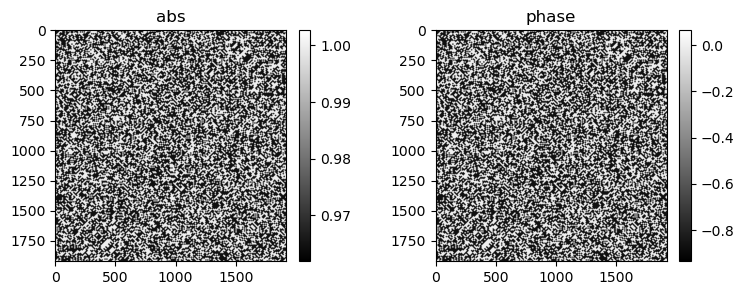

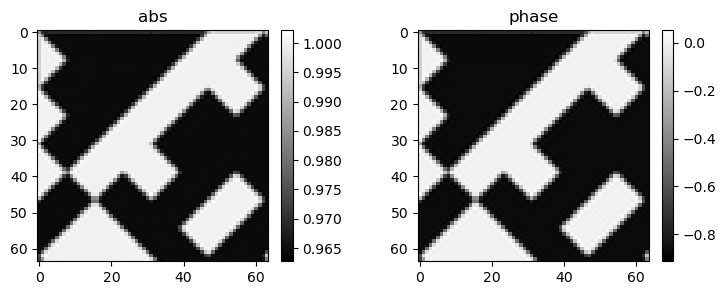

In [7]:
import random
import xraylib
import scipy.ndimage as ndimage



random.seed(10)
nill = nee
ill_global = np.zeros([1,nill,nill],dtype='bool')
for k in  range(ill_global.shape[0]):
    ill0 = np.zeros([nill*nill],dtype='bool')
    ill_ids = random.sample(range(0, nill*nill), int(nill*nill*0.55))
    ill0[ill_ids] = 1
    ill_global[k] = ill0.reshape(nill,nill)

# form codes for simulations
nill = int(nee*voxelsize//(ill_feature_size*2))*2
ill = np.zeros([1,nill,nill],dtype='bool')
for k in  range(ill.shape[0]):
    ill0 = ill_global[k]
    ill[k] = ill0[ill0.shape[0]//2-nill//2:ill0.shape[0]//2+(nill)//2,ill0.shape[1]//2-nill//2:ill0.shape[1]//2+(nill)//2]#.reshape(nill,nill)
    
ill = ndimage.zoom(ill,[1,nee/nill,nee/nill],order=0,grid_mode=True,mode='grid-wrap')

# print(np.sum(ill),2*ne*2*ne//2)

# fsize = int(2*ne//nill)+1
# x = np.linspace(-1,1,fsize)
# [x,y] = np.meshgrid(x,x)
# circ = x**2+y**2<0.9
# ill = ill*0
# while cp.sum(ill)<2*ne*2*ne//2:
#     stx = int(cp.random.randint(ill.shape[1]-fsize))
#     sty = int(cp.random.randint(ill.shape[1]-fsize))
#     # print(stx,sty,ill[:,sty:sty+fsize,stx:stx+fsize].shape)
#     ill[:,sty:sty+fsize,stx:stx+fsize]+=circ
#     if cp.amax(ill[:,sty:sty+fsize,stx:stx+fsize]>1):
#         ill[:,sty:sty+fsize,stx:stx+fsize]-=circ

#     stx = int(cp.random.randint(ill.shape[1]-fsize))
#     sty = int(cp.random.randint(ill.shape[1]-fsize))

# ill = ill*0 + np.random.random(ill.shape)*2

# ill_ids = np.array(ill_ids)
# idsy = ill_ids//(nill)
# idsx = ill_ids%(nill)
# ill[:]=0

# ill_ids = random.sample(range(0, 2*ne*2*ne), int(2*ne*2*ne/2))
# ill0 = np.zeros([2*ne*2*ne],dtype='bool')
# ill0[ill_ids] = 1
# ill[k] = ill0.reshape(2*ne,2*ne)

# for k in range(len(ill_ids)):
#     if idsy[k]*fsize+fsize<=ill.shape[1] and idsx[k]*fsize+fsize<=ill.shape[1]:
#         ill[:,idsy[k]*fsize:idsy[k]*fsize+fsize,idsx[k]*fsize:idsx[k]*fsize+fsize]=circ
# print(np.sum(ill),2*ne*2*ne//2)


# print(ill.shape)
# for k in range(ill.shape[1]//fsize):
#     for j in range(ill.shape[2]//fsize):
#         ill[0,k*fsize:(k+1)*fsize,j*fsize:(j+1)*fsize]*=circ

# print(nill)

delta = 1-xraylib.Refractive_Index_Re('Au',energy,19.3)
beta = xraylib.Refractive_Index_Im('Au',energy,19.3)
print(beta,delta,delta/beta)

# delta = 1-xraylib.Refractive_Index_Re('C21H25ClO',energy,1.19)
# beta = xraylib.Refractive_Index_Im('C21H25ClO',energy,1.19)

print(beta,delta,delta/beta)
thickness = code_thickness/voxelsize # thickness in pixels


# form Transmittance function

Rill = ill*(-delta+1j*beta)*thickness 
Rill=ndimage.rotate(Rill, 45, axes=(2, 1), reshape=False, order=3, mode='reflect',
                   prefilter=True)

v = np.arange(-nee//2,nee//2)/2/ne
[vx,vy] = np.meshgrid(v,v)
v = np.exp(-2*(vx**2+vy**2))
fill = np.fft.fftshift(np.fft.fftn(np.fft.fftshift(Rill)))
Rill = np.fft.fftshift(np.fft.ifftn(np.fft.fftshift(fill*v)))
Rill = Rill.astype('complex64')

code = np.exp(1j * Rill * voxelsize * 2 * np.pi / wavelength).astype('complex64')

# code=code*0+1
mshow_polar(code[0],show)

mshow_polar(code[0,:n//8,:n//8],show)



In [8]:
print('voxelsize',voxelsize)
print('field of view',voxelsize*n)
print('detector voxel size after binning', voxelsize*magnifications[0])
print('detector field of view', voxelsize*n*magnifications[0])

voxelsize 1.8281249999999997e-07
field of view 9.359999999999998e-05
detector voxel size after binning -1.2e-05
detector field of view -0.006144


### Compute holographic projections for all positions

In [9]:
def _fwd_holo(psi, shifts_code, prb):
    prb = cp.array(prb)
    psi = cp.array(psi)

    data = cp.zeros([psi.shape[0], npos, n, n], dtype='complex64')
    for i in range(npos):
        psir = psi.copy()
        prbr = cp.tile(prb, [psi.shape[0], 1, 1])
        
        # shift and crop the code 
        psir = S(psir, shifts_code[:, i])
        nee = psir.shape[1]
        psir = psir[:, nee//2-n//2-pad:nee/2+n//2+pad, nee//2-n//2-pad:nee/2+n//2+pad]
        psir *= prbr
        
        # propagate the code to the probe plane
        psir = G(psir, wavelength, voxelsize, distances[i])
        
        # unpad
        data[:, i] = psir[:, pad:n+pad, pad:n+pad]
    return data

def fwd_holo(psi, prb):
    return _fwd_holo(psi, shifts_code,  prb)

def _fwd_holo0(prb):    
    data = cp.zeros([1,npos, n, n], dtype='complex64')
    for j in range(npos):
        # propagate illumination 
        data[:,j] = G(prb, wavelength, voxelsize, distances[0])[:,pad:n+pad,pad:n+pad]        
    return data

def fwd_holo0(prb): 
    return _fwd_holo0(prb)

# Apply the forward transform
psi = cp.array(code)
prb = cp.array(prb)
shifts_code = cp.array(shifts_code)
fpsi = fwd_holo(psi, prb)
fref = fwd_holo0(prb)

### Take squared absolute value to simulate data on the detector

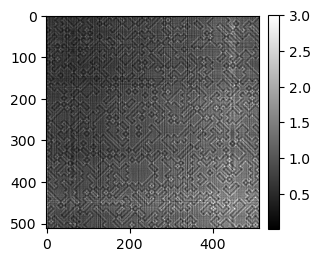

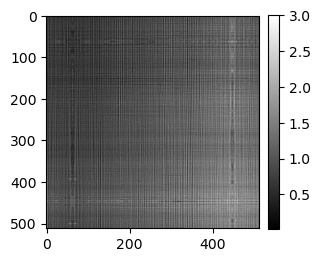

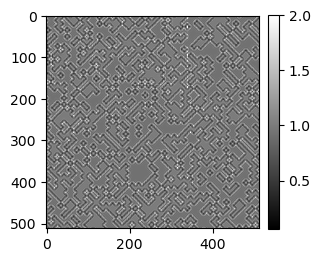

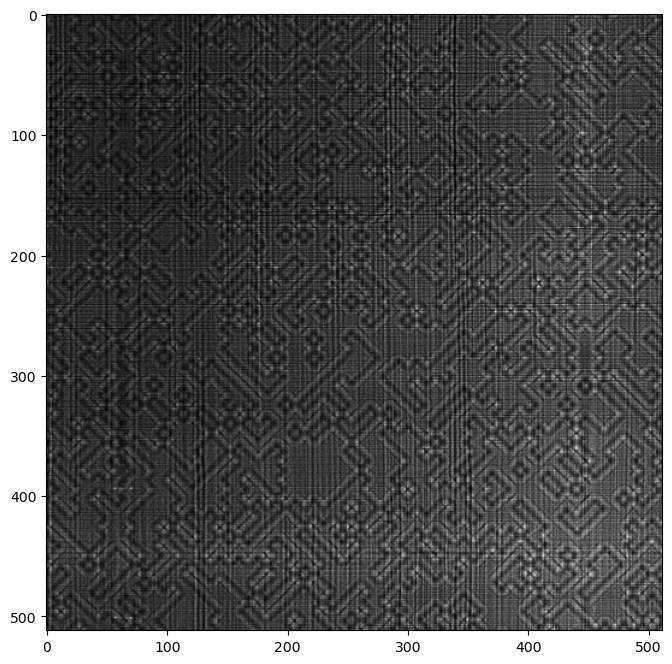

In [10]:
data = np.abs(fpsi)**2
ref = np.abs(fref)**2
mshow(data[0,0],show,vmax=3)
mshow(ref[0,0],show,vmax=3)
if noise>0:
    data_noise = cp.random.poisson(data*noise).astype('float32')/noise
    ref_noise = cp.random.poisson(ref*noise).astype('float32')/noise
    mshow(data[0,0]-data_noise[0,0],show)
    data=data_noise
    ref=ref_noise

mshow(data[0,0]/ref[0,0],show,vmax=2)
plt.figure(figsize=(8,8))
plt.imshow(data[0,0].get(),cmap='gray')
plt.show()

### Save data and shifts

In [11]:
print(f'{path}/data/data_{k}_{flg}.tiff')
for k in range(npos):
    write_tiff(data[:,k],f'{path}/data/data_{k}_{flg}')
for k in range(npos):
    write_tiff(ref[:,k],f'{path}/data/ref_{k}_{flg}')
np.save(f'{path}/data/code_{flg}',code)
np.save(f'{path}/data/shifts_code_{flg}', shifts_code)
np.save(f'{path}/data/prb_{flg}', prb)
np.save(f'{path}/data/psi_{flg}', psi)


/data2/vnikitin/nfp_codes/data/data_0_512_1_49_-0.0195_0_code.tiff
